<a href="https://colab.research.google.com/github/dillionverma/facial-sentiment-intensity-analysis/blob/master/ConvResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Data_CNN/ADFES-BIV.zip", 'r')
zip_ref.extractall("/tmp/ADFES")
zip_ref.close()

In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import os
import matplotlib.pyplot as plt    # for plotting the images
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D,AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD,Adadelta
from keras import optimizers
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

In [ ]:
def video_to_frames(filename, folder):
  """Extract frames from filename into folder"""
  # Make folder
  if not os.path.exists(folder):
    os.mkdir(folder)
  count = 0
  # capturing the video from the given path
  cap = cv2.VideoCapture(filename)
  # Extract framerate
  frameRate = cap.get(5)
  x=1
  while(cap.isOpened()):
      frameId = cap.get(1) #current frame number
      ret, frame = cap.read()
      if (ret != True):
          break
      # if (frameId % math.floor(frameRate) == 0):
      filename ="frame%03d.jpg" % count;count+=1
      cv2.imwrite(os.path.join(folder, filename), frame)
  cap.release()


In [ ]:
# load in the data 
video_files = []
for file in glob.glob("/tmp/ADFES/*.wmv"):
    video_files.append(file)

print(video_files)

for file in video_files[3:]:
  video_to_frames(file, os.path.basename(file.split('.')[0]))

['/tmp/ADFES/M02-Neutral-3.wmv', '/tmp/ADFES/M12-Neutral-2.wmv', '/tmp/ADFES/F02-Embarrass-low.wmv', '/tmp/ADFES/F02-Contempt-high.wmv', '/tmp/ADFES/M04-Anger-med.wmv', '/tmp/ADFES/F03-Neutral-3.wmv', '/tmp/ADFES/F02-Sadness-high.wmv', '/tmp/ADFES/M08-Embarrass-low.wmv', '/tmp/ADFES/F04-Contempt-high.wmv', '/tmp/ADFES/F01-Neutral-1.wmv', '/tmp/ADFES/M03-Fear-high.wmv', '/tmp/ADFES/M11-Fear-low.wmv', '/tmp/ADFES/M11-Fear-med.wmv', '/tmp/ADFES/M03-Anger-med.wmv', '/tmp/ADFES/M04-Pride-high.wmv', '/tmp/ADFES/M12-Contempt-high.wmv', '/tmp/ADFES/F04-Surprise-med.wmv', '/tmp/ADFES/F04-Fear-med.wmv', '/tmp/ADFES/F01-Sadness-high.wmv', '/tmp/ADFES/M12-Surprise-med.wmv', '/tmp/ADFES/F04-Fear-high.wmv', '/tmp/ADFES/M03-Neutral-1.wmv', '/tmp/ADFES/M12-Sadness-low.wmv', '/tmp/ADFES/M02-Pride-low.wmv', '/tmp/ADFES/F05-Disgust-low.wmv', '/tmp/ADFES/M03-Embarrass-high.wmv', '/tmp/ADFES/F04-Anger-med.wmv', '/tmp/ADFES/M03-Contempt-high.wmv', '/tmp/ADFES/M08-Disgust-low.wmv', '/tmp/ADFES/F03-Fear-med.w

In [ ]:
!pip3 install facenet_pytorch

In [ ]:
from facenet_pytorch import MTCNN
from PIL import Image
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize, CenterCrop, RandomResizedCrop, Scale

def tosquare(bbox):
    """Convert bounding box to square by elongating shorter side."""
    x1, y1, x2, y2 = bbox
    w = x2-x1
    h = y2-y1
    x = x1
    y = y1
    if h > w:
        diff = h - w
        y += diff // 2
        h -= diff
        # print(x, y, w, h)
    elif w > h:
        diff = w - h
        x += diff // 2
        w -= diff
        # print(x, y, w, h)
    if w != h:
        logging.debug(f"{w} is not {h}")

    return (x, y, x + w, y + h)

def findFace(image):
  model = MTCNN(keep_all=True)        # pretrained multitask CNN for finding faces
  bboxes, probs = model.detect(image)   # returns a list of bounding boxes and a list of probabilities for each detected face

  # print(bboxes)
  # print("Accuracy: ", probs)

  face_img = image.crop(tosquare(bboxes[0]))
  face_img = image.crop(tosquare(bboxes[0]))
  imgplot = plt.imshow(face_img)
  plt.show()
  return face_img

def process_face(img):
  # # Call function to return image of face
  face_img = findFace(img)

  transform = Compose([
                      Grayscale(1), # https://pillow.readthedocs.io/en/stable/reference/Image.html
                      Resize(32),
                      ToTensor(),
                      Normalize(mean=[0.5],std=[0.5]),
                      ])
  
  return transform(face_img)

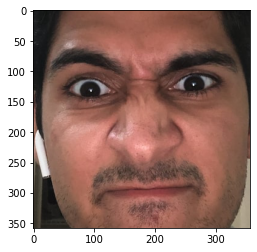

In [ ]:
def populate_data(): 
  columns = ['image', 'frame number', 'emotion', 'model']
  data = [[] , [], [], []]
  # frames = ['03', '06', '09', '12', '15', '17', '19', '21', '23', '25']
  #frames = ['13', '19', '20', '22', '25']
  frames = list(range(0, 26))
  for file in glob.glob("/content/*high"):
      for i, frame in enumerate(frames):
        filename = ''
        if frame >= 10:
          filename = file + '/frame0{}.jpg'.format(frame)
        else:
          filename = file + '/frame00{}.jpg'.format(frame) 
        
        # get model name
        metadata = filename.split('/')[2].split('-')
        model = metadata[0]
        emotion = metadata[1]

        # print(model, emotion)

        # print(filename)
        # get image
        img = Image.open(filename)
        # imgplot = plt.imshow(img)
        # plt.show()
        image_data = process_face(img).tolist()
        data[0].append(image_data)
        # print(data[0][-1])
        data[1].append(i)
        data[2].append(emotion)
        data[3].append(model)
  
  print('all done')
  return data

In [ ]:
full_data = populate_data()

all done


In [ ]:
def get_particular_frames(data, frames):
  """
  frames: list of frames
  """
  classes = len(frames)
  new_data = [[], [], [], []]
  rows = len(data[0])
  for row in range(rows):
    for i in range(classes):
      if data[1][row] == frames[i]:
        new_data[0].append(data[0][row])
        new_data[1].append(i)
        new_data[2].append(data[2][row])
        new_data[3].append(data[3][row])

  return classes, new_data

In [ ]:
# frames = [3, 6, 9, 12, 15, 17, 19, 21, 23, 25]
# frames = [13, 15, 19, 20, 21, 22, 23, 25]
frames = [13, 19, 20, 22, 25]
classes, data = get_particular_frames(full_data, frames)

In [ ]:
def split_test_train(data, train, test):
  # x = np.asarray(data[0])
  # x = x.reshape(
  #     x.shape[0],
  #     32, 32,
  #     1
  # )
  
  # y = np.asarray(data[1])
  # y = y.reshape(y.shape[0], 1)

  # return train_test_split(x, y, test_size=0.25, random_state=0)
  x_train = np.asarray(data[0][:train])
  x_train = x_train.reshape(
      x_train.shape[0],
      32, 32,
      1
  )
  
  y_train = np.asarray(data[1][:train])
  y_train = y_train.reshape(y_train.shape[0], 1)

  x_val = np.asarray(data[0][train:train+test])
  x_val = x_val.reshape(
      x_val.shape[0],
      32, 32,
      1
  )
  
  y_val = np.asarray(data[1][train:train+test])
  y_val = y_val.reshape(y_val.shape[0], 1)

  x_test = np.asarray(data[0][train+test:])
  x_test = x_test.reshape(
      x_test.shape[0],
      32, 32,
      1
  )
  y_test = np.asarray(data[1][train+test:])
  y_test = y_test.reshape(y_test.shape[0], 1)
  
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split_test_train(data, 450*1, 45*1)

In [ ]:
# CLEAR TF.KERAS SESSION
tf.keras.backend.clear_session()

seed_value = 0

#START A NEW TF SESSION
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
tf.compat.v1.keras.backend.set_session(
    sess
)

input_shape = (32, 32, 1)

## THIS IS DECENT ##
model = Sequential()

filters = 2
increment = 1

model.add(Convolution2D(filters=filters, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Convolution2D(filters=filters + increment * 1, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.01))

model.add(Convolution2D(filters=filters + increment * 2, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.01))
# 
model.add(Convolution2D(filters=filters + increment * 3, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.01))

model.add(Convolution2D(filters=filters + increment * 4, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.01))

model.add(Flatten())
# model.add(Dense(528, activation='relu'))
# model.add(Dropout(0.4))

model.add(Dense(classes, activation='softmax'))

# model.summary()

In [ ]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001,name="RMSProp")
sgd = tf.keras.optimizers.SGD(learning_rate=0.5, momentum=0.01, name="SGD")
ada = tf.keras.optimizers.Adagrad(learning_rate=0.9, name="Adagrad")

model.compile(optimizer=rmsprop,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(
    x_train,          
    y_train,          
    epochs = 50,
    batch_size = 75,      
    # shuffle = True,   
    # callbacks=[lr_reducer, checkpointer, early_stopper]
)

# history = model.fit(x_train, y_train, epochs=20, validation_split=0.3)

Epoch 1/50
450/450 [==============================] - 0s 717us/step - loss: 1.6098 - accuracy: 0.2400
Epoch 2/50
450/450 [==============================] - 0s 349us/step - loss: 1.6096 - accuracy: 0.2556
Epoch 3/50
450/450 [==============================] - 0s 364us/step - loss: 1.6096 - accuracy: 0.1933
Epoch 4/50
450/450 [==============================] - 0s 355us/step - loss: 1.6094 - accuracy: 0.3600
Epoch 5/50
450/450 [==============================] - 0s 375us/step - loss: 1.6095 - accuracy: 0.1378
Epoch 6/50
450/450 [==============================] - 0s 381us/step - loss: 1.6094 - accuracy: 0.2600
Epoch 7/50
450/450 [==============================] - 0s 364us/step - loss: 1.6093 - accuracy: 0.2644
Epoch 8/50
450/450 [==============================] - 0s 360us/step - loss: 1.6094 - accuracy: 0.2156
Epoch 9/50
450/450 [==============================] - 0s 354us/step - loss: 1.6094 - accuracy: 0.2756
Epoch 10/50
450/450 [==============================] - 0s 374us/step - loss: 1.609

In [ ]:
val_loss, val_acc = model.evaluate(x_val,  y_val)

print('\nValidation accuracy:', val_acc)

45/45 [==============================] - 0s 1ms/step

Validation accuracy: 0.3333333432674408


In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test)

print('\nTest accuracy:', test_acc)

45/45 [==============================] - 0s 415us/step

Test accuracy: 0.7333333492279053


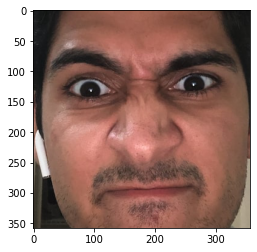

In [ ]:
yatin = Image.open('/content/sample_data/yk.jpg')
yk_processed = process_face(yatin).tolist()

yk_predict = np.asarray([yk_processed])
yk_predict = yk_predict.reshape(
    1,
    32, 32,
    1
)

In [ ]:
model.predict(yk_predict)

array([[0.20986344, 0.17544739, 0.19927052, 0.26161286, 0.15380572]],
      dtype=float32)

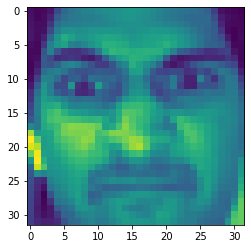

In [ ]:
plt.imshow(yk_processed[0])
plt.show()

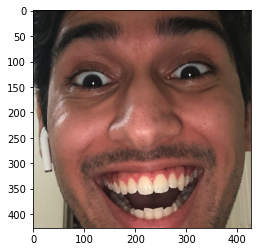

array([[0.20958176, 0.1787816 , 0.199096  , 0.2545545 , 0.15798604]],
      dtype=float32)

In [ ]:
yk_happy = Image.open('/content/sample_data/yk_happy.jpg')
yk_happy_processed = process_face(yk_happy).tolist()

yk_happy_predict = np.asarray([yk_happy_processed])
yk_happy_predict = yk_happy_predict.reshape(
    1,
    32, 32,
    1
)

model.predict(yk_happy_predict)

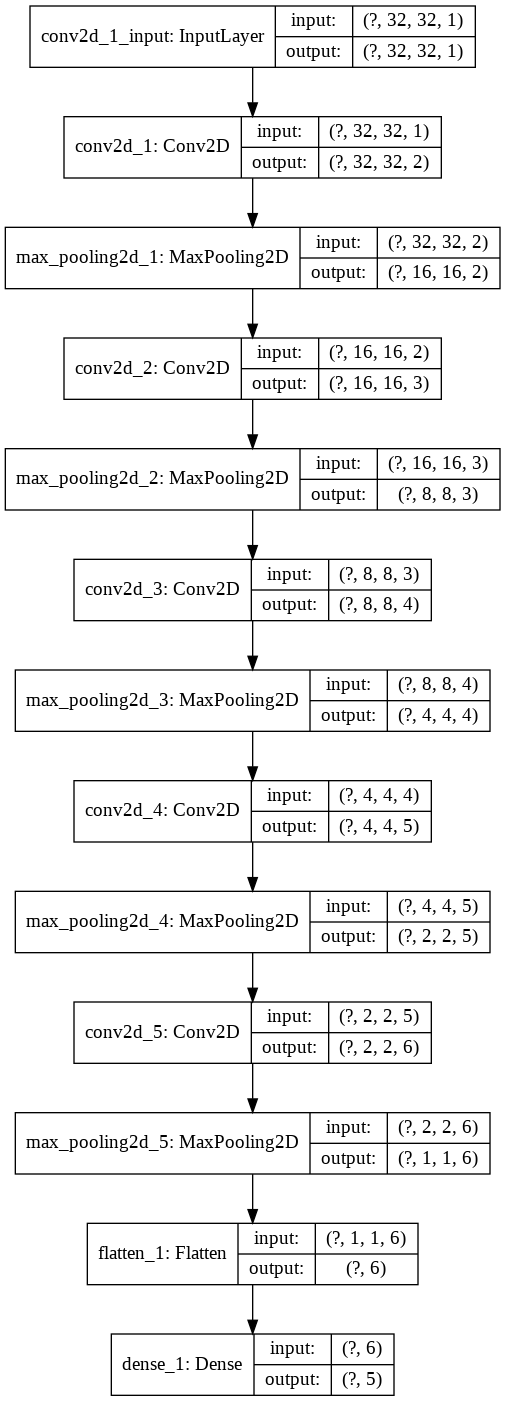

In [ ]:
# Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    # show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)